In [ ]:
!set CUDA_VISIBLE_DEVICES=0
!python tools/train.py -c configs/rtdetr/rtdetr_r50vd_6x_hrsid.yml

Not init distributed mode.
Start training
Load PResNet50 state_dict


Traceback (most recent call last):
  File "tools/train.py", line 50, in <module>
    main(args)
  File "tools/train.py", line 36, in main
    solver.fit()
  File "e:\Ziheng_projects\rtdetr_sar\tools\..\src\solver\det_solver.py", line 21, in fit
    self.train()
  File "e:\Ziheng_projects\rtdetr_sar\tools\..\src\solver\solver.py", line 45, in train
    self.setup()
  File "e:\Ziheng_projects\rtdetr_sar\tools\..\src\solver\solver.py", line 28, in setup
    self.model = dist.warp_model(cfg.model.to(device), cfg.find_unused_parameters, cfg.sync_bn)
  File "e:\Ziheng_projects\rtdetr_sar\tools\..\src\core\yaml_config.py", line 44, in model
    self._model = create(self.yaml_cfg['model'])
  File "e:\Ziheng_projects\rtdetr_sar\tools\..\src\core\yaml_utils.py", line 123, in create
    cls_kwargs[k] = create(_cfg['_name'])
  File "e:\Ziheng_projects\rtdetr_sar\tools\..\src\core\yaml_utils.py", line 148, in create
    return cls(**cls_kwargs)
  File "e:\Ziheng_projects\rtdetr_sar\tools\..\src\zoo

In [ ]:
hrsid_category2name = {
    1: 'ship'
}

hrsid_category2label = {k: i for i, k in enumerate(hrsid_category2name.keys())}
hrsid_label2category = {v: k for k, v in hrsid_category2label.items()}

hrsid_category2label, hrsid_label2category

({1: 0}, {0: 1})

: 

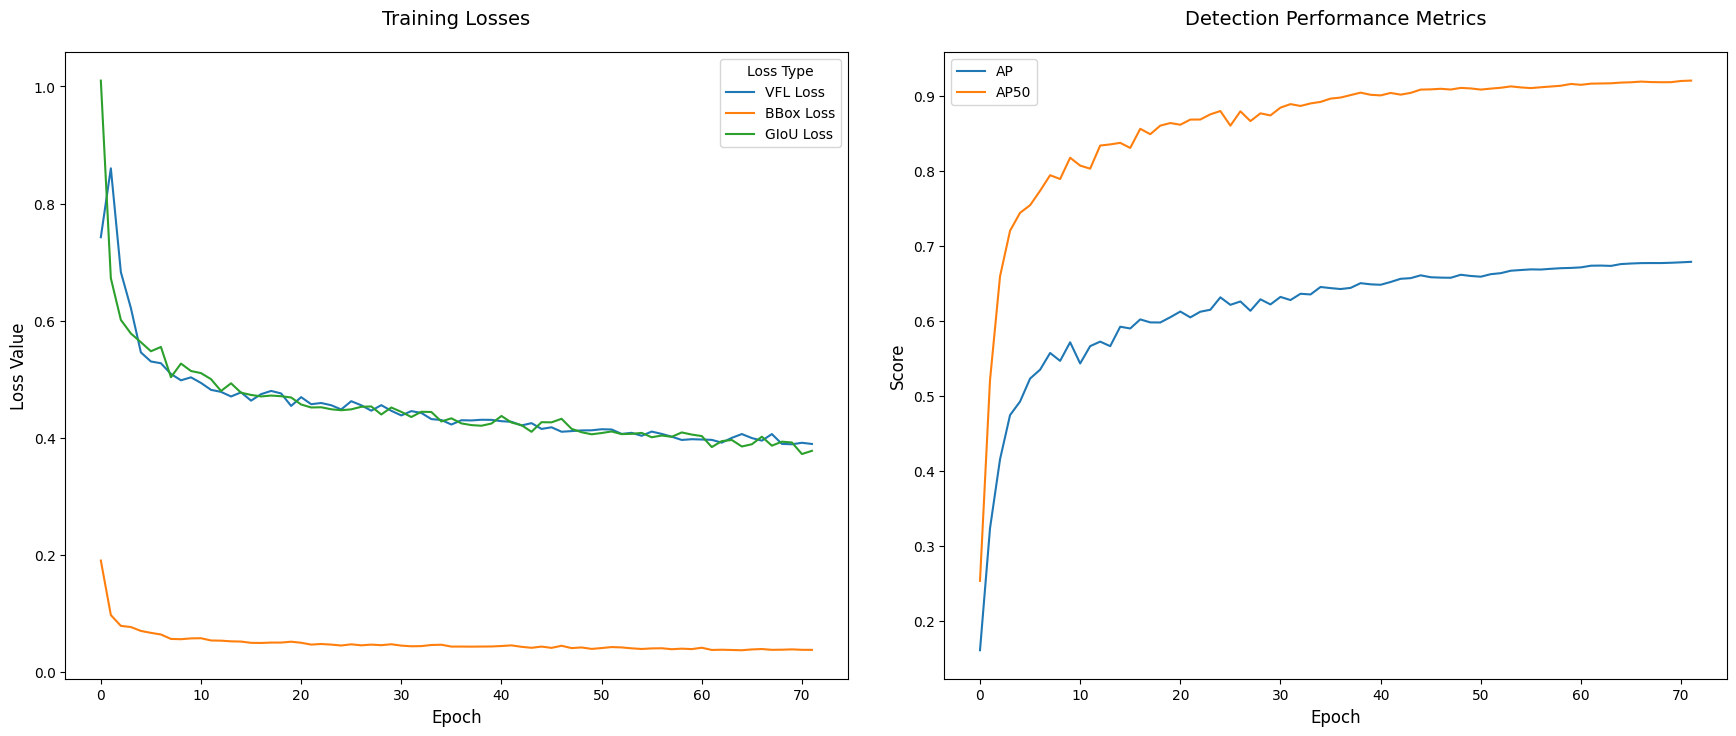

In [16]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 解析日志数据
logs = []
for line in open('output/rtdetr_r50vd_6x_hrsid/log.txt', 'r'):
    log_entry = json.loads(line)
    logs.append(log_entry)

df = pd.DataFrame(logs)

# 提取AP和AP50
df['AP'] = df['test_coco_eval_bbox'].apply(lambda x: x[0])
df['AP50'] = df['test_coco_eval_bbox'].apply(lambda x: x[1])

# 绘制损失曲线
loss_columns = ['train_loss_vfl', 'train_loss_bbox', 'train_loss_giou']
loss_df = df.melt(id_vars=['epoch'], 
                  value_vars=loss_columns, 
                  var_name='Loss Type', 
                  value_name='Value')

# 重命名损失类型
loss_names = {
    'train_loss_vfl': 'VFL Loss',
    'train_loss_bbox': 'BBox Loss',
    'train_loss_giou': 'GIoU Loss'
}
loss_df['Loss Type'] = loss_df['Loss Type'].map(loss_names)

plt.figure(figsize=(18, 8))  # 调整画布尺寸为横向布局

# 损失曲线
plt.subplot(1, 2, 1)
sns.lineplot(data=loss_df, x='epoch', y='Value', hue='Loss Type', 
             style='Loss Type', dashes=False)
plt.title('Training Losses', fontsize=14, pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)

# AP曲线
plt.subplot(1, 2, 2)
sns.lineplot(data=df, x='epoch', y='AP', label='AP')
sns.lineplot(data=df, x='epoch', y='AP50', label='AP50')
plt.title('Detection Performance Metrics', fontsize=14, pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout(pad=3.0)
plt.show()

带有Ground Truth边界框的图像已保存为 gt_P0096_1200_2000_3600_4400.jpg

Processing P0096_1200_2000_3600_4400.jpg...
Results saved as results_P0096_1200_2000_3600_4400.jpg
对比图已保存为 comparison_P0096_1200_2000_3600_4400.jpg


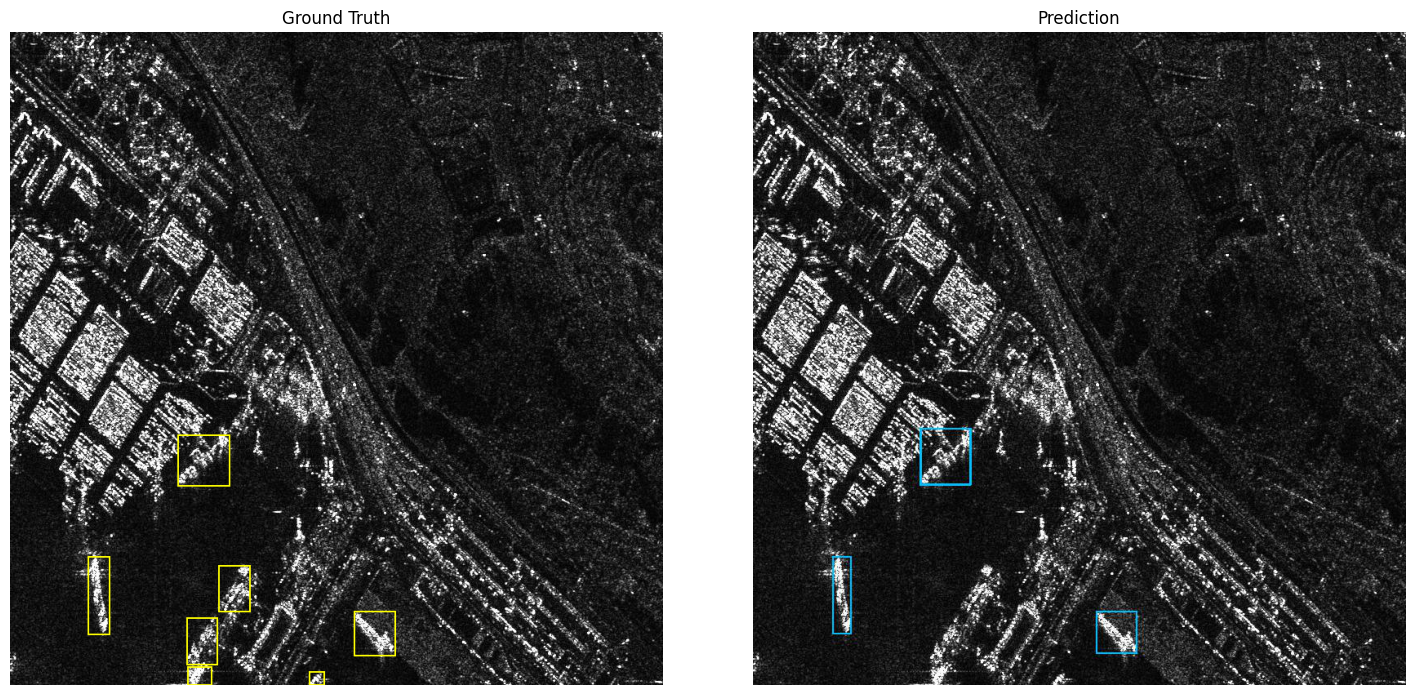

In [2]:
import json
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os
import shutil

# 指定图像路径
image_path = "data/HRSID/val/P0096_1200_2000_3600_4400.jpg"
# 指定标注文件路径（COCO格式）
annotation_file = "data/HRSID/annotations/val.json"

# 加载图像
image = Image.open(image_path).convert('RGB')
image_name = image_path.split('/')[-1]

# 加载标注数据
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# 找到图像对应的image_id
image_id = None
for img in annotations['images']:
    if img['file_name'] == image_name:
        image_id = img['id']
        break

if image_id is None:
    print(f"找不到图像 {image_name} 对应的ID")
else:
    # 找到所有属于该图像的标注
    gt_boxes = []
    for ann in annotations['annotations']:
        if ann['image_id'] == image_id:
            # COCO格式的边界框是 [x, y, width, height]
            # 转换为 [x1, y1, x2, y2] 格式
            x, y, w, h = ann['bbox']
            bbox = [x, y, x+w, y+h]
            gt_boxes.append(bbox)
    
    # 在图像上绘制GT边界框
    draw = ImageDraw.Draw(image)
    for box in gt_boxes:
        draw.rectangle(list(box), outline='yellow', width=2)
    
    # 保存带有GT边界框的图像
    gt_image_path = f"gt_{image_name}"
    image.save(gt_image_path)
    print(f"带有Ground Truth边界框的图像已保存为 {gt_image_path}")

    print(f"\nProcessing {os.path.basename(image_path)}...")
    os.system(f'python tools/infer.py -c configs/rtdetr/rtdetr_r18vd_6x_hrsid.yml -r output/rtdetr_r18vd_6x_hrsid/checkpoint0011.pth -f "{image_path}"')
    
    # 重命名输出结果以避免覆盖
    image_name = os.path.basename(image_path).split('.')[0]
    
    # 使用shutil.move代替mv命令
    if os.path.exists("results_0.jpg"):
        output_path = f"results_{image_name}.jpg"
        shutil.move("results_0.jpg", output_path)
        print(f"Results saved as {output_path}")
    else:
        print("Warning: results_0.jpg not found")

    # 显示原始预测图像和带GT边界框的图像对比
    pred_image_path = f"results_{image_name.split('.')[0]}.jpg"
    if os.path.exists(pred_image_path):
        plt.figure(figsize=(15, 7))
        
        plt.subplot(1, 2, 1)
        plt.imshow(np.array(image))
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(np.array(Image.open(pred_image_path)))
        plt.title("Prediction")
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(f"comparison_{image_name.split('.')[0]}.jpg", dpi=300)
        print(f"对比图已保存为 comparison_{image_name.split('.')[0]}.jpg")
    else:
        print(f"预测结果图像 {pred_image_path} 不存在")